In [33]:
# ============================================================
# Forecasting Ambient Temperature with RNNs on Jena Climate
# Author: Mintesnot Alemayehu Kassa
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:


# ------------------------------------------------------------
# 1. Configuration
# ------------------------------------------------------------

DATA_PATH = "data/jena_climate_2009_2016.csv"  # adjust if needed
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

TARGET_COL = "T (degC)"
HORIZONS = [6, 12, 36]    # 6*10min=1h, 12*10min=2h, 36*10min=6h
INPUT_LENGTH = 48         # 48*10min = 8h of history
STRIDE = 6                # slide windows by 1 hour
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [35]:


# ------------------------------------------------------------
# 2. Load and inspect data
# ------------------------------------------------------------

df = pd.read_csv(DATA_PATH)
# Parse datetime
df["datetime"] = pd.to_datetime(df["Date Time"], format="%d.%m.%Y %H:%M:%S")
df = df.sort_values("datetime").set_index("datetime")

# Drop the original string column
df_features = df.drop(columns=["Date Time"])

print(df_features.head())
print(df_features.describe())


                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
datetime                                                                 
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
datetime                                                                   
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   
2009-01-01 00:40:00          3.26          3.07          0.19       1.92   
2009-01-01 00:50:00      

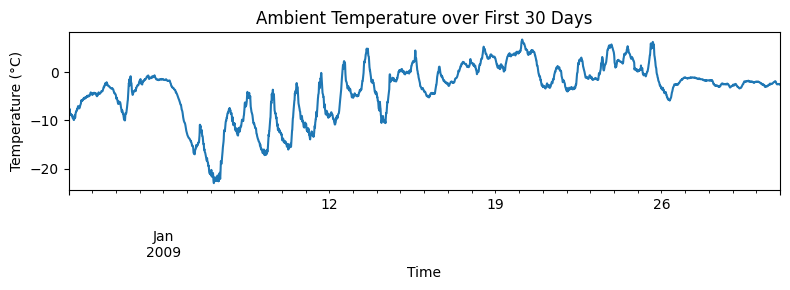

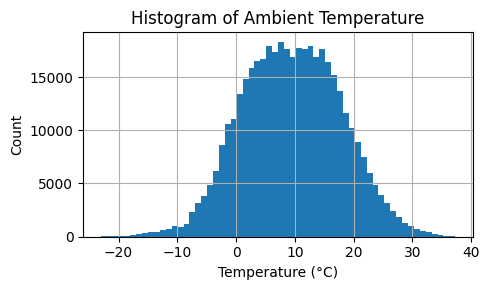

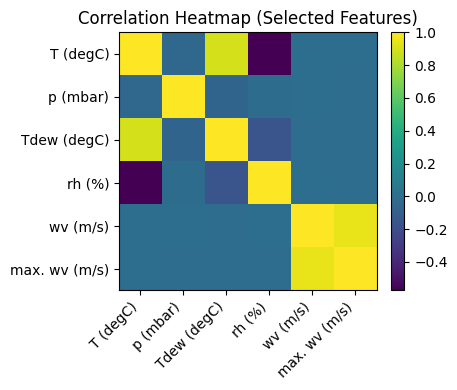

In [36]:


# ------------------------------------------------------------
# 3. Basic EDA and figures for the report
# ------------------------------------------------------------

# 3.1 Temperature over first ~30 days
n_10min_per_day = 6 * 24  # 6 samples/hour * 24 hours
window_30_days = n_10min_per_day * 30

plt.figure(figsize=(8, 3))
df_features[TARGET_COL].iloc[:window_30_days].plot()
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Ambient Temperature over First 30 Days")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig_temp_time.png"), dpi=300)
plt.show()
plt.close()

# 3.2 Temperature histogram
plt.figure(figsize=(5, 3))
df_features[TARGET_COL].hist(bins=60)
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.title("Histogram of Ambient Temperature")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig_temp_hist.png"), dpi=300)
plt.show()
plt.close()

# 3.3 Correlation heatmap for selected features
selected_cols = [TARGET_COL, "p (mbar)", "Tdew (degC)", "rh (%)",
                 "wv (m/s)", "max. wv (m/s)"]
corr = df_features[selected_cols].corr()

plt.figure(figsize=(5, 4))
im = plt.imshow(corr.values, interpolation="nearest")
plt.xticks(range(len(selected_cols)), selected_cols, rotation=45, ha="right")
plt.yticks(range(len(selected_cols)), selected_cols)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Heatmap (Selected Features)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig_corr_heatmap.png"), dpi=300)
plt.show()
plt.close()


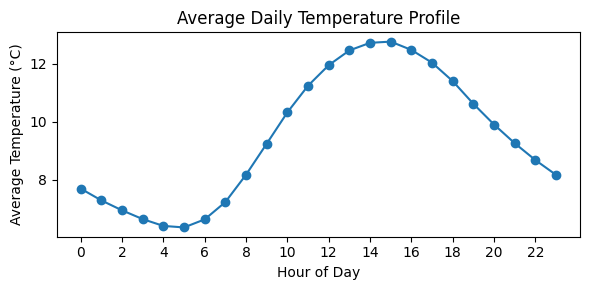

In [37]:
# ------------------------------------------------------------
# 3.4 Daily temperature profile (new figure for report)
# ------------------------------------------------------------

df_daily = df_features.copy()
df_daily["hour"] = df_daily.index.hour

mean_temp_by_hour = df_daily.groupby("hour")[TARGET_COL].mean()

plt.figure(figsize=(6, 3))
plt.plot(mean_temp_by_hour.index, mean_temp_by_hour.values, marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Average Temperature (°C)")
plt.title("Average Daily Temperature Profile")
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig_daily_profile.png"), dpi=300)
plt.show()
plt.close()


In [38]:


# ------------------------------------------------------------
# 4. Normalization and window generation
# ------------------------------------------------------------

data_values = df_features.values.astype("float32")
feature_names = df_features.columns.tolist()
target_idx = feature_names.index(TARGET_COL)

# chronological train/val/test split in terms of rows
n = len(data_values)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

train_data = data_values[:train_end]
val_data = data_values[train_end:val_end]
test_data = data_values[val_end:]

# compute normalization statistics from train only
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

def standardize(x):
    return (x - mean) / std

train_data_norm = standardize(train_data)
val_data_norm = standardize(val_data)
test_data_norm = standardize(test_data)

print("Train:", train_data_norm.shape, "Val:", val_data_norm.shape, "Test:", test_data_norm.shape)

def make_windows(data_norm, horizons, input_length, stride, target_index):
    """
    Given a normalized 2D array (time, features),
    create (X, y) where:
      X: (num_windows, input_length, num_features)
      y: (num_windows, len(horizons)) - standardized temperature for each horizon.
    """
    X_list, y_list = [], []
    max_h = max(horizons)
    n = len(data_norm)

    for start in range(0, n - input_length - max_h, stride):
        end = start + input_length
        window = data_norm[start:end]  # shape (input_length, num_features)
        base = end - 1
        ys = []
        for h in horizons:
            idx = base + h
            ys.append(data_norm[idx, target_index])
        X_list.append(window)
        y_list.append(ys)

    X = np.stack(X_list)
    y = np.stack(y_list)
    return X, y

X_train, y_train = make_windows(train_data_norm, HORIZONS, INPUT_LENGTH, STRIDE, target_idx)
X_val, y_val = make_windows(val_data_norm, HORIZONS, INPUT_LENGTH, STRIDE, target_idx)
X_test, y_test = make_windows(test_data_norm, HORIZONS, INPUT_LENGTH, STRIDE, target_idx)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

num_features = X_train.shape[2]
num_horizons = len(HORIZONS)


Train: (252330, 14) Val: (84110, 14) Test: (84111, 14)
X_train: (42041, 48, 14) y_train: (42041, 3)
X_val: (14005, 48, 14) y_val: (14005, 3)
X_test: (14005, 48, 14) y_test: (14005, 3)


In [39]:


# ------------------------------------------------------------
# 5. Baseline: Persistence
# ------------------------------------------------------------

# For each window, persistence predicts last temp in window for all horizons
def persistence_predictions(X, target_index, horizons):
    last_temp = X[:, -1, target_index]  # shape (num_samples,)
    return np.repeat(last_temp[:, None], len(horizons), axis=1)

y_pred_pers_val = persistence_predictions(X_val, target_idx, HORIZONS)
y_pred_pers_test = persistence_predictions(X_test, target_idx, HORIZONS)

rmse_pers_val = np.sqrt(mean_squared_error(y_val, y_pred_pers_val, multioutput="raw_values"))
rmse_pers_test = np.sqrt(mean_squared_error(y_test, y_pred_pers_test, multioutput="raw_values"))
r2_pers_val = r2_score(y_val, y_pred_pers_val, multioutput="raw_values")
r2_pers_test = r2_score(y_test, y_pred_pers_test, multioutput="raw_values")

print("Persistence RMSE (test):", rmse_pers_test)
print("Persistence R2   (test):", r2_pers_test)


Persistence RMSE (test): [0.11549275 0.20388289 0.48343676]
Persistence R2   (test): [0.9841088  0.95048535 0.72186697]


In [40]:


# ------------------------------------------------------------
# 6. Baselines: Linear Regression and Ridge
# ------------------------------------------------------------

# Flatten windows for linear models: (N, input_length * num_features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

def evaluate_linear_model(model, name):
    model.fit(X_train_flat, y_train)
    y_val_pred = model.predict(X_val_flat)
    y_test_pred = model.predict(X_test_flat)

    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred, multioutput="raw_values"))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput="raw_values"))
    r2_val = r2_score(y_val, y_val_pred, multioutput="raw_values")
    r2_test = r2_score(y_test, y_test_pred, multioutput="raw_values")

    print(f"\n{name} RMSE (val):  {rmse_val}")
    print(f"{name} RMSE (test): {rmse_test}")
    print(f"{name} R2   (val):  {r2_val}")
    print(f"{name} R2   (test): {r2_test}")

    return {
        "name": name,
        "rmse_val": rmse_val,
        "rmse_test": rmse_test,
        "r2_val": r2_val,
        "r2_test": r2_test,
        "y_test_pred": y_test_pred,
    }

# 6.1 Plain Linear Regression
lin_reg = LinearRegression()
results_lin = evaluate_linear_model(lin_reg, "Linear Regression")

# 6.2 Ridge Regression with simple alpha search using time-series CV on train
alphas = [0.1, 1.0, 10.0]
tscv = TimeSeriesSplit(n_splits=3)

best_alpha = None
best_cv_rmse = np.inf

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    fold_rmses = []
    for tr_idx, val_idx in tscv.split(X_train_flat):
        X_tr, X_vl = X_train_flat[tr_idx], X_train_flat[val_idx]
        y_tr, y_vl = y_train[tr_idx], y_train[val_idx]
        ridge.fit(X_tr, y_tr)
        y_pred_vl = ridge.predict(X_vl)
        rmse_fold = np.sqrt(mean_squared_error(y_vl, y_pred_vl, multioutput="raw_values")).mean()
        fold_rmses.append(rmse_fold)
    avg_rmse = np.mean(fold_rmses)
    print(f"alpha={alpha}, CV mean RMSE={avg_rmse:.4f}")
    if avg_rmse < best_cv_rmse:
        best_cv_rmse = avg_rmse
        best_alpha = alpha

print("Best alpha for Ridge:", best_alpha)

ridge_best = Ridge(alpha=best_alpha)
results_ridge = evaluate_linear_model(ridge_best, "Ridge Regression")


/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/minte/Documents/Projects/ML/env/lib/


Linear Regression RMSE (val):  [0.09237202 0.15375255 0.34158736]
Linear Regression RMSE (test): [0.68409795 1.0623226  2.6124167 ]
Linear Regression R2   (val):  [0.9868902  0.96368253 0.8208381 ]
Linear Regression R2   (test): [ 0.4424494  -0.34426618 -7.121911  ]


/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:292: RuntimeWarning: divide by zero encountered in matmul
  UTy = U.T @ y
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:292: RuntimeWarning: overflow encountered in matmul
  UTy = U.T @ y
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:292: RuntimeWarning: invalid value encountered in matmul
  UTy = U.T @ y
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:296: RuntimeWarning: divide by zero encountered in matmul
  return (Vt.T @ d_UT_y).T
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:296: RuntimeWarning: overflow encountered in matmul
  return (Vt.T @ d_UT_y).T
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:296: RuntimeWarning: invalid valu

alpha=0.1, CV mean RMSE=0.1957


/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:292: RuntimeWarning: divide by zero encountered in matmul
  UTy = U.T @ y
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:292: RuntimeWarning: overflow encountered in matmul
  UTy = U.T @ y
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:292: RuntimeWarning: invalid value encountered in matmul
  UTy = U.T @ y
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:296: RuntimeWarning: divide by zero encountered in matmul
  return (Vt.T @ d_UT_y).T
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:296: RuntimeWarning: overflow encountered in matmul
  return (Vt.T @ d_UT_y).T
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:296: RuntimeWarning: invalid valu

alpha=1.0, CV mean RMSE=0.1933
alpha=10.0, CV mean RMSE=0.1917
Best alpha for Ridge: 10.0

Ridge Regression RMSE (val):  [0.08519407 0.14531663 0.33324295]
Ridge Regression RMSE (test): [0.7941503 1.159933  3.716197 ]
Ridge Regression R2   (val):  [0.9888485  0.96755844 0.82948446]
Ridge Regression R2   (test): [  0.24863124  -0.60264814 -15.4350395 ]


/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/Users/minte/Documents/Projects/ML/env/lib/python3.9/site-packages/sklearn/linear_model/_base.py:281: RuntimeWarning: invalid value e

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 48, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,115 (23.89 KB)

 Trainable params: 6,115 (23.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
329/329 - 3s - 9ms/step - loss: 0.1718 - val_loss: 0.0690
Epoch 2/20
329/329 - 2s - 7ms/step - loss: 0.0818 - val_loss: 0.0607
Epoch 3/20
329/329 - 2s - 6ms/step - loss: 0.0723 - val_loss: 0.0599
Epoch 4/20
329/329 - 2s - 6ms/step - loss: 0.0679 - val_loss: 0.0547
Epoch 5/20
329/329 - 2s - 5ms/step - loss: 0.0644 - val_loss: 0.0531
Epoch 6/20
329/329 - 2s - 5ms/step - loss: 0.0615 - val_loss: 0.0528
Epoch 7/20
329/329 - 2s - 5ms/step - loss: 0.0603 - val_loss: 0.0498
Epoch 8/20
329/329 - 2s - 6ms/step - loss: 0.0586 - val_loss: 0.0483
Epoch 9/20
329/329 - 2s - 5ms/step - loss: 0.0576 - val_loss: 0.0479
Epoch 10/20
329/329 - 2s - 5ms/step - loss: 0.0563 - val_loss: 0.0474
Epoch 11/20
329/329 - 2s - 5ms/step - loss: 0.0553 - val_loss: 0.0449
Epoch 12/20
329/329 - 2s - 5ms/step - loss: 0.0546 - val_loss: 0.0464
Epoch 13/20
329/329 - 2s - 5ms/step - loss: 0.0538 - val_loss: 0.0437
Epoch 14/20
329/329 - 2s - 5ms/step - loss: 0.0531 - val_loss: 0.0464
Epoch 15/20
329/329 - 2s - 6m

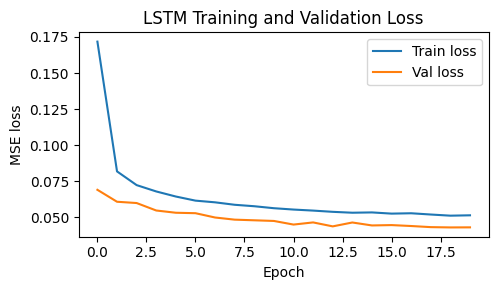

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

LSTM RMSE (test): [0.09189977 0.14477879 0.32124847]
LSTM R2   (test): [0.9899382  0.9750321  0.87718385]


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 48, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,707 (18.39 KB)

 Trainable params: 4,707 (18.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
329/329 - 3s - 8ms/step - loss: 0.1430 - val_loss: 0.0700
Epoch 2/20
329/329 - 2s - 6ms/step - loss: 0.0859 - val_loss: 0.0618
Epoch 3/20
329/329 - 2s - 6ms/step - loss: 0.0751 - val_loss: 0.0592
Epoch 4/20
329/329 - 2s - 6ms/step - loss: 0.0704 - val_loss: 0.0595
Epoch 5/20
329/329 - 2s - 6ms/step - loss: 0.0671 - val_loss: 0.0588
Epoch 6/20
329/329 - 2s - 6ms/step - loss: 0.0646 - val_loss: 0.0522
Epoch 7/20
329/329 - 2s - 6ms/step - loss: 0.0615 - val_loss: 0.0495
Epoch 8/20
329/329 - 2s - 6ms/step - loss: 0.0585 - val_loss: 0.0470
Epoch 9/20
329/329 - 2s - 7ms/step - loss: 0.0564 - val_loss: 0.0465
Epoch 10/20
329/329 - 2s - 6ms/step - loss: 0.0549 - val_loss: 0.0462
Epoch 11/20
329/329 - 2s - 6ms/step - loss: 0.0539 - val_loss: 0.0450
Epoch 12/20
329/329 - 2s - 6ms/step - loss: 0.0534 - val_loss: 0.0433
Epoch 13/20
329/329 - 2s - 6ms/step - loss: 0.0527 - val_loss: 0.0431
Epoch 14/20
329/329 - 2s - 6ms/step - loss: 0.0515 - val_loss: 0.0432
Epoch 15/20
329/329 - 2s - 6m

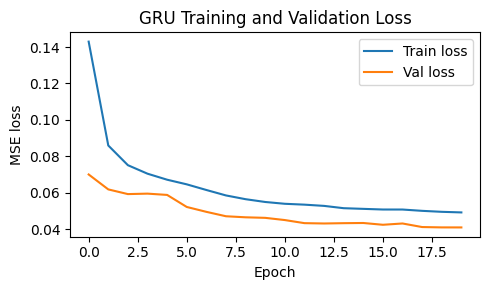

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

GRU RMSE (test): [0.0897391  0.1418356  0.31492898]
GRU R2   (test): [0.99040574 0.9760369  0.8819683 ]


In [41]:


# ------------------------------------------------------------
# 7. RNN models: LSTM and GRU
# ------------------------------------------------------------

def build_rnn_model(model_type, input_length, num_features, num_horizons, units=32, dropout=0.2):
    inputs = keras.Input(shape=(input_length, num_features))
    if model_type.lower() == "lstm":
        x = layers.LSTM(units, return_sequences=False)(inputs)
    elif model_type.lower() == "gru":
        x = layers.GRU(units, return_sequences=False)(inputs)
    else:
        raise ValueError("model_type must be 'lstm' or 'gru'")
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_horizons)(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse"
    )
    return model

batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000, seed=RANDOM_SEED).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

def train_rnn(model_type, units=32, epochs=20, patience=3, tag=""):
    model = build_rnn_model(model_type, INPUT_LENGTH, num_features, num_horizons, units=units)
    model.summary()

    ckpt_path = f"best_{model_type.lower()}_{tag}.keras"
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=2
    )

    # Plot training/validation loss for the report
    plt.figure(figsize=(5, 3))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title(f"{model_type.upper()} Training and Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"fig_loss_curves_{model_type.lower()}.png"), dpi=300)
    plt.show()
    plt.close()

    # Evaluate on test
    y_test_pred = model.predict(test_ds)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput="raw_values"))
    r2_test = r2_score(y_test, y_test_pred, multioutput="raw_values")

    print(f"\n{model_type.upper()} RMSE (test):", rmse_test)
    print(f"{model_type.upper()} R2   (test):", r2_test)

    return model, {
        "rmse_test": rmse_test,
        "r2_test": r2_test,
        "y_test_pred": y_test_pred
    }

# Train LSTM
lstm_model, results_lstm = train_rnn("lstm", units=32, epochs=20, patience=5, tag="32u")

# Train GRU
gru_model, results_gru = train_rnn("gru", units=32, epochs=20, patience=5, tag="32u")


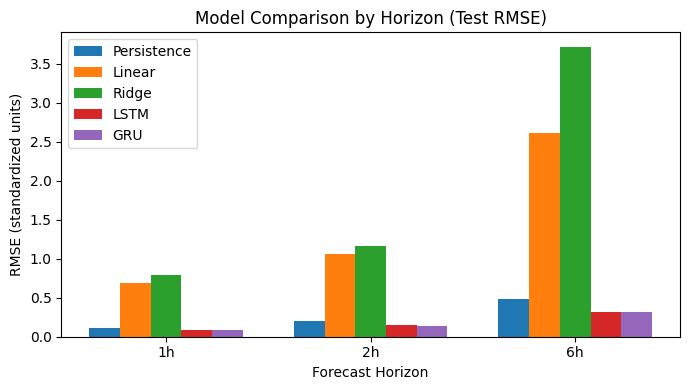

In [42]:


# ------------------------------------------------------------
# 8. Summary: RMSE bar plot
# ------------------------------------------------------------

# Collect test RMSE for bar plot (per horizon)
model_names = ["Persistence", "Linear", "Ridge", "LSTM", "GRU"]
rmse_matrix = np.vstack([
    rmse_pers_test,
    results_lin["rmse_test"],
    results_ridge["rmse_test"],
    results_lstm["rmse_test"],
    results_gru["rmse_test"],
])  # shape (5 models, 3 horizons)

x = np.arange(len(HORIZONS))  # horizons index
width = 0.15

plt.figure(figsize=(7, 4))
for i, name in enumerate(model_names):
    plt.bar(x + i * width, rmse_matrix[i], width, label=name)

plt.xticks(x + width * 2, [f"{h*10//60}h" for h in HORIZONS])
plt.xlabel("Forecast Horizon")
plt.ylabel("RMSE (standardized units)")
plt.title("Model Comparison by Horizon (Test RMSE)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig_rmse_bar.png"), dpi=300)
plt.show()
plt.close()


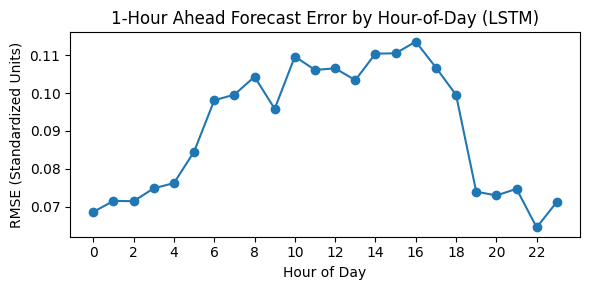

In [43]:
# ------------------------------------------------------------
# 8.x Error by hour-of-day (new figure for report)
# ------------------------------------------------------------

# Reconstruct timestamps for each test window
data_index = df_features.index
n = len(data_index)

train_end = int(0.6 * n)
val_end = int(0.8 * n)

test_index = data_index[val_end:]
n_test = len(test_index)

one_hour_h = HORIZONS[0]  # typically 6 ( = 1 hour)
max_h = max(HORIZONS)

target_timestamps_1h = []

for start in range(0, n_test - INPUT_LENGTH - max_h, STRIDE):
    end = start + INPUT_LENGTH
    base = end - 1
    t_idx = base + one_hour_h
    target_timestamps_1h.append(test_index[t_idx])

target_timestamps_1h = pd.to_datetime(target_timestamps_1h)

# Choose model (LSTM/GRU)
y_pred_test = results_lstm["y_test_pred"][:, 0]
y_true_test = y_test[:, 0]

df_err = pd.DataFrame({
    "timestamp": target_timestamps_1h,
    "true": y_true_test,
    "pred": y_pred_test
})

df_err["hour"] = df_err["timestamp"].dt.hour
df_err["sq_err"] = (df_err["true"] - df_err["pred"])**2

rmse_by_hour = (df_err.groupby("hour")["sq_err"].mean())**0.5

plt.figure(figsize=(6, 3))
plt.plot(rmse_by_hour.index, rmse_by_hour.values, marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("RMSE (Standardized Units)")
plt.title("1-Hour Ahead Forecast Error by Hour-of-Day (LSTM)")
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig_error_by_hour.png"), dpi=300)
plt.show()
plt.close()


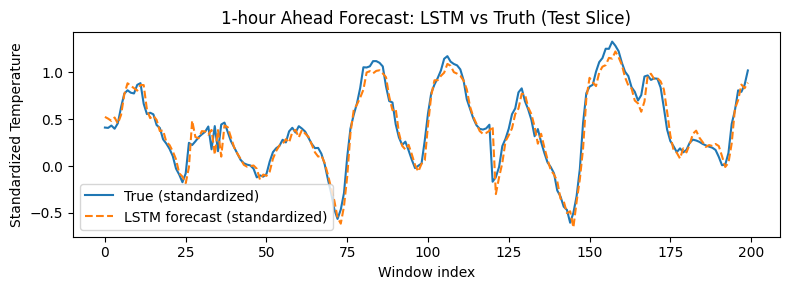

All done. Figures saved in: figures


In [44]:

# ------------------------------------------------------------
# 9. Example forecast vs truth plot
# ------------------------------------------------------------

# Take a slice of the test set for visualization (e.g. first 200 windows at 1-hour horizon)
n_plot = 200
h_1h_index = 0  # horizon index for 1 hour (HORIZONS[0] == 6)

true_1h = y_test[:n_plot, h_1h_index]
pred_1h_lstm = results_lstm["y_test_pred"][:n_plot, h_1h_index]

plt.figure(figsize=(8, 3))
plt.plot(true_1h, label="True (standardized)")
plt.plot(pred_1h_lstm, label="LSTM forecast (standardized)", linestyle="--")
plt.xlabel("Window index")
plt.ylabel("Standardized Temperature")
plt.title("1-hour Ahead Forecast: LSTM vs Truth (Test Slice)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "fig_forecast_example.png"), dpi=300)
plt.show()
plt.close()

print("All done. Figures saved in:", FIG_DIR)